### Imports

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
import scipy.stats as sps
from scipy.interpolate import interp1d

### Constants

In [96]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7
%config InlineBackend.figure_format = 'retina'

### Functions

In [74]:
from IPython.core.debugger import set_trace

def prepare_cases(cases, min_cases=25, win_size=7):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(
        win_size,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    idx_start = np.searchsorted(smoothed, min_cases)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [4]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

### Get Confidence Intervals

In [5]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

In [6]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

### Get County Data from Github

In [7]:
import io
import requests

In [26]:
url="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
s=requests.get(url).content
county_df = (pd
             .read_csv(io.StringIO(s.decode('utf-8')))
             .assign(date = lambda d: pd.to_datetime(d.date))
            )
county_cases = (county_df
             .set_index(["county", "date"])
             .drop(columns=["fips", "deaths", "state"])
             .sort_index()
             .squeeze()
            )

In [9]:
import re

counties = sorted(list(set([county for county, date in county_cases.index])))

def get_county_like(search_string):
    """Search for county name using regex."""
    pattern = re.compile(search_string, re.I)
    return [county for county in counties if pattern.search(county)]

def get_county_cases(county_name):
    """Get rows where county name matches `county_name`."""
    return county_cases.xs(county_name)

def county_to_admissions(county_cases, hosp_rate=0.025, market_share=0.15):
    """
    Calculated expected admissions for hospital in county with the assuming
    the respective hospitalization rates and market_share.
    """
    return np.floor(county_cases * hosp_rate * market_share)

### Get $R_t$ for Each Day of Actuals

In [92]:
def display_counties(counties, convert_to_admits=False, **kwargs):
    if type(counties) is not list:
        counties = [counties]
    fig, axes = plt.subplots(nrows=len(counties), ncols=2, figsize=(1200/72,(400 * len(counties))/72))
    fig.set_facecolor('w')
    for county_name, axes in zip(counties, axes):
        cases = get_county_cases(county_name)
        if convert_to_admits:
            cases = county_to_admissions(cases, **kwargs)
        cases_prepped, smoothed = prepare_cases(cases, min_cases=5)

        # Get cases plot
        
        ax = axes[0]
        ax.plot(
            cases_prepped.index, 
            cases_prepped.values, 
            c='k',
            linestyle=':',
            alpha=.5,
            label='Actual',
        )
        ax.set_title(f"Cases per Day ({county_name})")
            
        ax.plot(smoothed.index, 
                smoothed.values,
                label='Smoothed',
                )
        
        ax.legend()

        
        # Get R_t plot
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

        # Confidence Intervals
        # Note that this takes a while to execute - it's not the most efficient algorithm
        hdis = highest_density_interval(posteriors, p=.9)

        most_likely = posteriors.idxmax().rename('ML')

        # Look into why you shift -1
        result = pd.concat([most_likely, hdis], axis=1)

        # Plot R_t with intervals
        ax = axes[1]

        plot_rt(result, ax, county_name)
        ax.set_title(f'Real-time $R_t$ for {county_name}')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [82]:
get_county_like("new y")

['New York City']

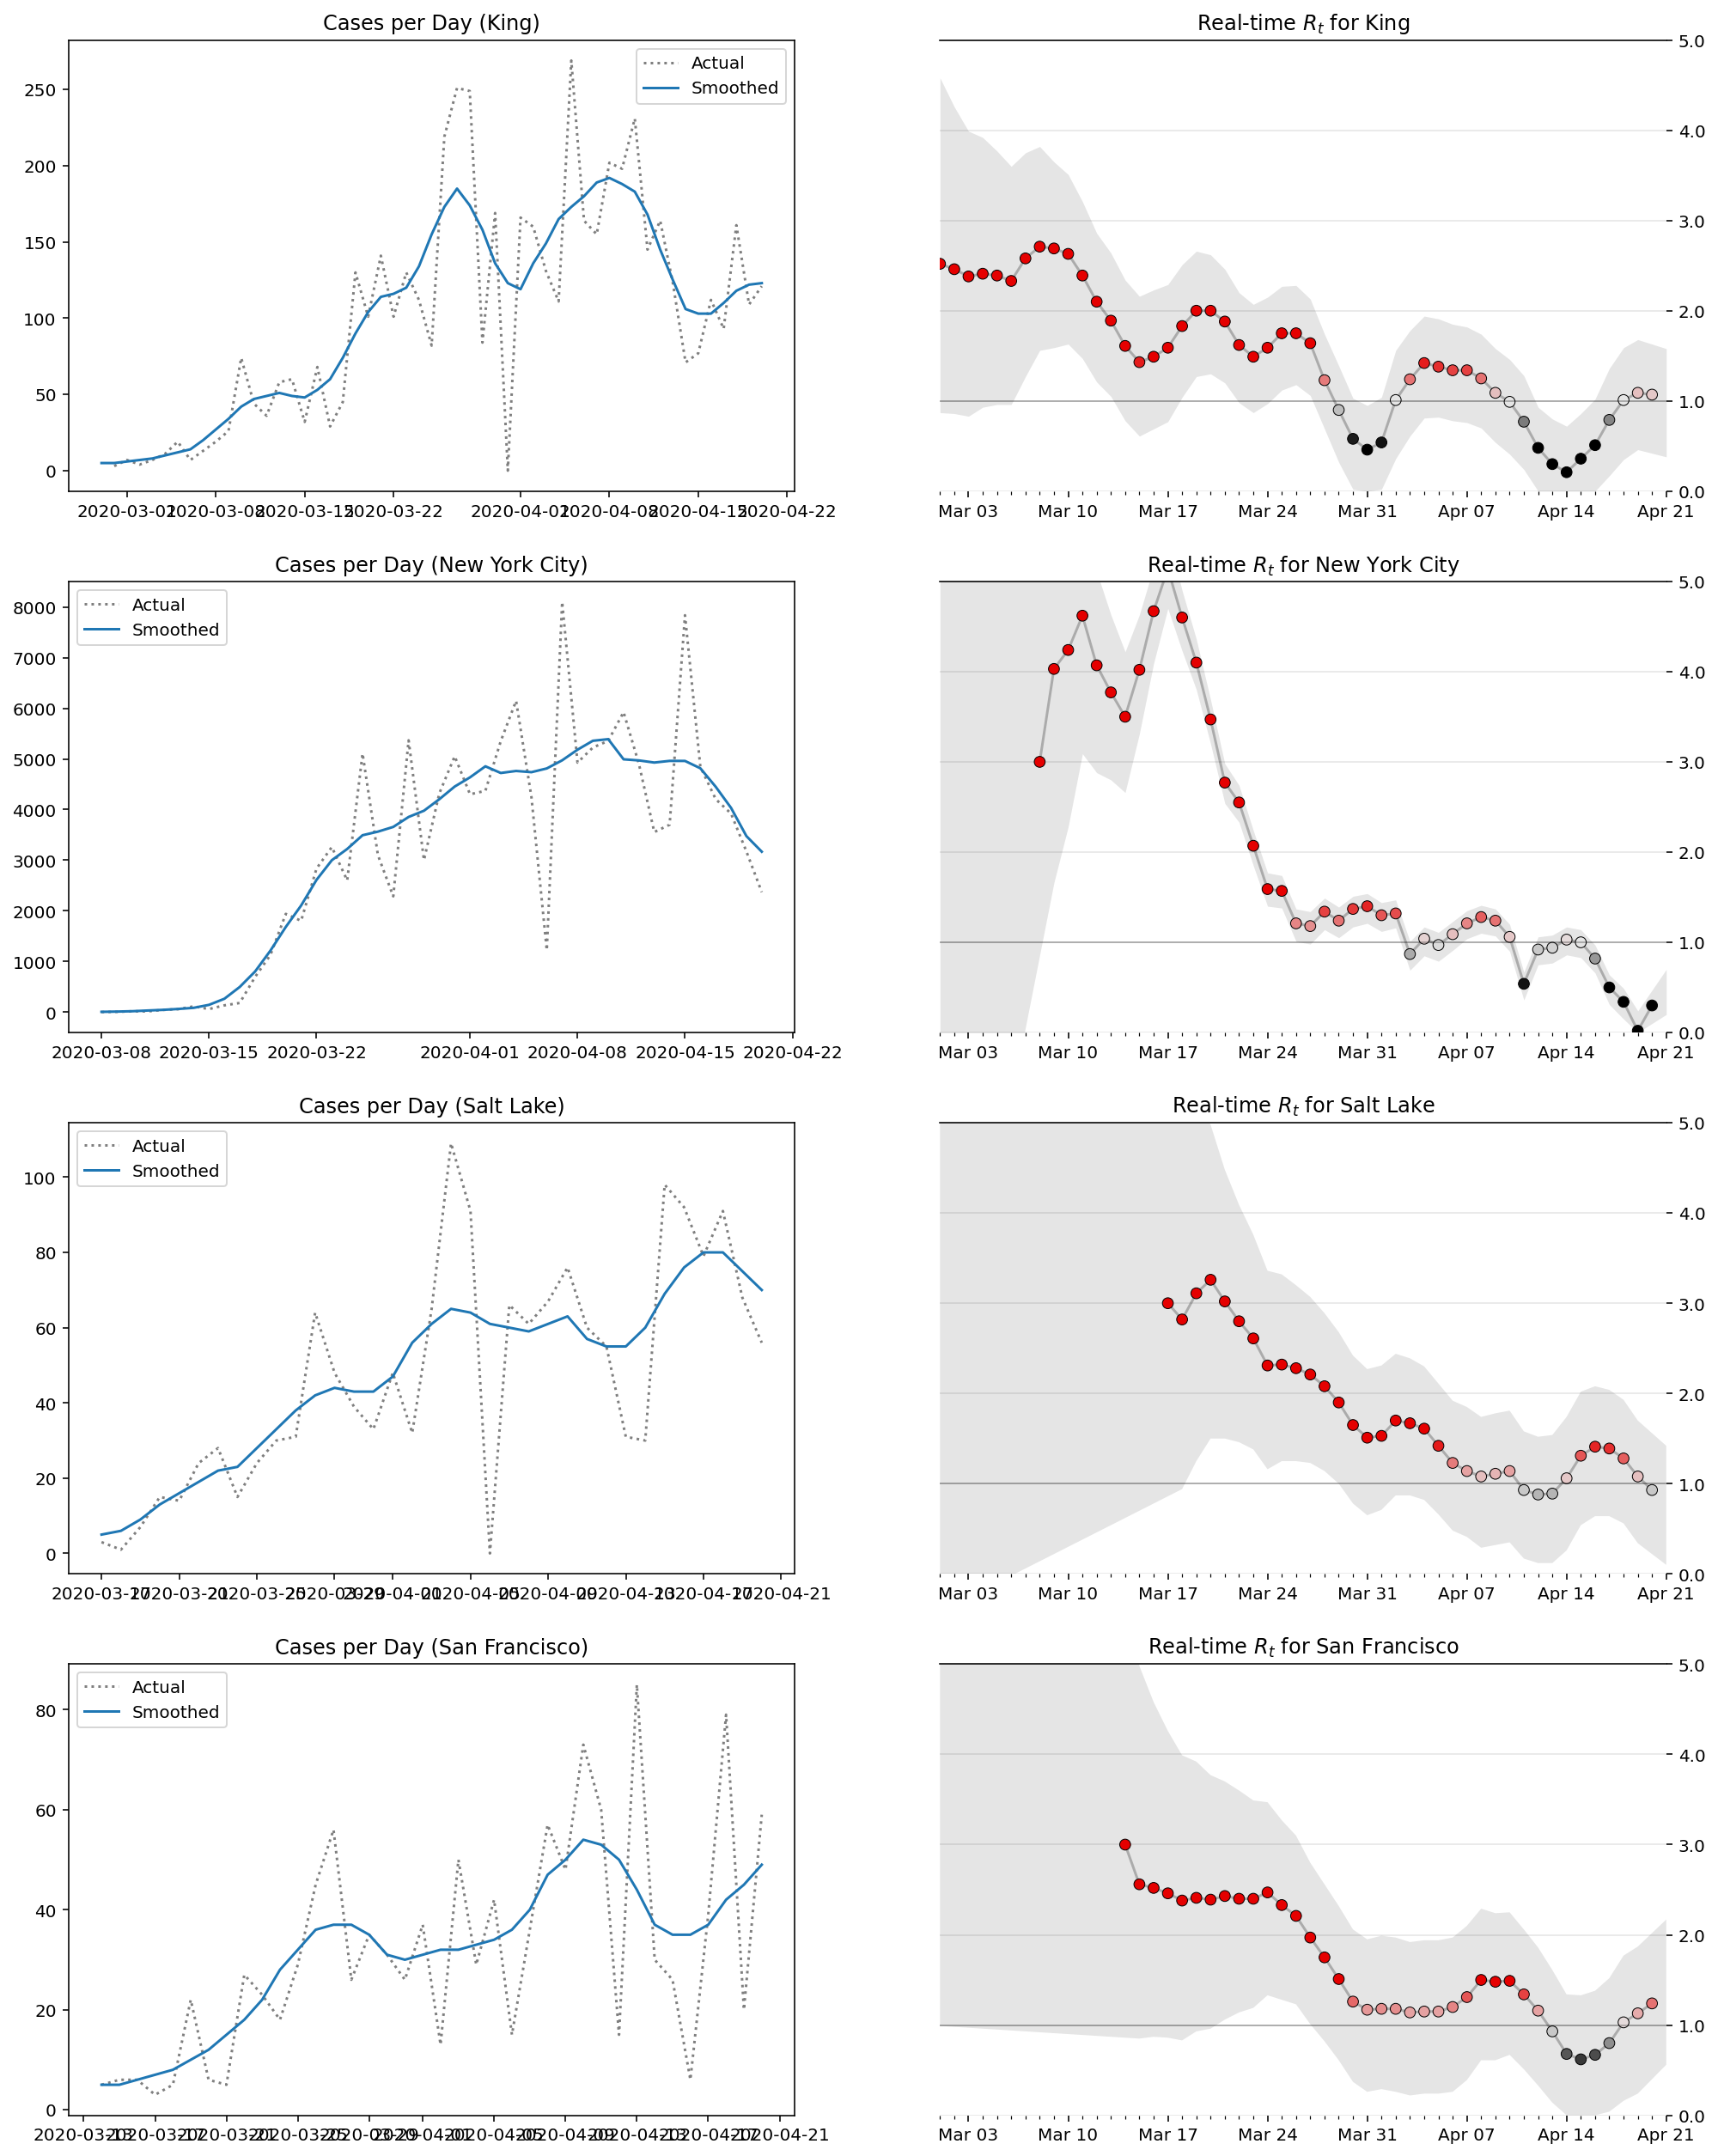

In [97]:
counties = ["King", "New York City", "Salt Lake", "San Francisco"]
display_counties(counties)

### Scratch

In [160]:
means = np.arange(5)
points = np.arange(-10, 10)
probs = sps.norm(loc=means, scale=5).pdf(points[:, None])#.pdf(np.array([1, 2, 3, 4, 5])[:, None])

In [161]:
probs

array([[0.01079819, 0.00709492, 0.00447891, 0.00271659, 0.00158309],
       [0.01579003, 0.01079819, 0.00709492, 0.00447891, 0.00271659],
       [0.02218417, 0.01579003, 0.01079819, 0.00709492, 0.00447891],
       [0.02994549, 0.02218417, 0.01579003, 0.01079819, 0.00709492],
       [0.03883721, 0.02994549, 0.02218417, 0.01579003, 0.01079819],
       [0.04839414, 0.03883721, 0.02994549, 0.02218417, 0.01579003],
       [0.05793831, 0.04839414, 0.03883721, 0.02994549, 0.02218417],
       [0.06664492, 0.05793831, 0.04839414, 0.03883721, 0.02994549],
       [0.07365403, 0.06664492, 0.05793831, 0.04839414, 0.03883721],
       [0.07820854, 0.07365403, 0.06664492, 0.05793831, 0.04839414],
       [0.07978846, 0.07820854, 0.07365403, 0.06664492, 0.05793831],
       [0.07820854, 0.07978846, 0.07820854, 0.07365403, 0.06664492],
       [0.07365403, 0.07820854, 0.07978846, 0.07820854, 0.07365403],
       [0.06664492, 0.07365403, 0.07820854, 0.07978846, 0.07820854],
       [0.05793831, 0.06664492, 0.

In [162]:
probs.shape

(20, 5)

In [163]:
normalized = probs / np.sum(probs, axis=0)

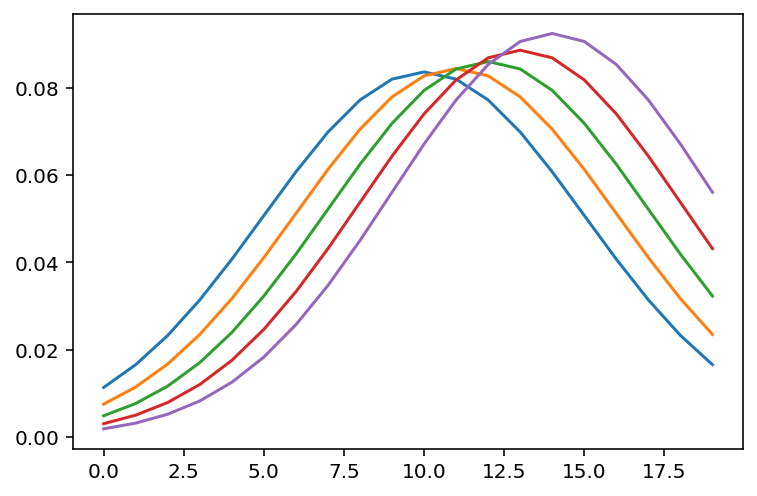

In [164]:
plt.plot(np.arange(probs.shape[0]), normalized)